In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

# Импорт необходимых библиотек и модулей
import pandas as pd
from statistic import data_diagnostics, calculate_completion_rate, time_pattern_analysis, compare_groups
from graphics import plot_dropout_line, plot_correlation_matrix
from dropout_predict import load_data, prepare_data, train_model, evaluate_model, feature_importance, visualize_decision_tree
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap

In [3]:
# Загрузка данных
registration_data = load_data('../data/registration.csv')
students_info_data = load_data('../data/students_info.csv')
students_assignments_data = load_data('../data/students_assignments.csv')
students_materials_data = load_data('../data/students_materials.csv')
feedback_data = load_data('../data/feedback.csv')

In [98]:
diagnostics = data_diagnostics(students_info_data)
diagnostics_df = pd.DataFrame(diagnostics)
display(diagnostics_df)

,mean,median,std,min,max
возраст,40.436667,40.000000,11.841580,20.000000,60.000000
опыт_работы,15.321667,15.000000,8.622574,1.000000,30.000000
оценка_итог,75.036281,75.028192,0.623428,73.240464,76.812604


In [48]:
completion_rate = calculate_completion_rate(students_info_data)
print(f"Уровень доходимости (COR): {completion_rate}%")

Уровень доходимости (COR): 90.0%


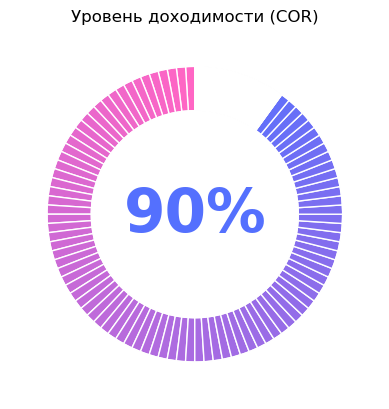

In [76]:
# Отображение уровня доходимости на круговой диаграмме
def plot_completion_rate(completion_rate):
    fig, ax = plt.subplots()
    size = 0.3

    # Создаем градиентный цвет
    cmap = LinearSegmentedColormap.from_list("grad", ["#ff66c4", "#5170ff"])
    colors = [cmap(i / 100) for i in range(100)]

    # Создаем сегменты для градиента
    wedges, texts = ax.pie([1]*100, startangle=90, colors=colors, radius=1, wedgeprops=dict(width=size, edgecolor='w'))
    
    # Создаем белый сегмент для незаполненной части
    ax.pie([completion_rate, 100 - completion_rate], startangle=90, colors=['none', 'white'], radius=1, wedgeprops=dict(width=size, edgecolor='w'))

    # Добавляем текст в центр круга
    ax.text(0, 0, f'{completion_rate:.0f}%', ha='center', va='center', fontsize=43, fontweight='bold', color='#5470fe')
    
    ax.set(aspect="equal", title='Уровень доходимости (COR)')
    plt.show()

plot_completion_rate(completion_rate)

In [80]:
# Проверка данных
print(registration_data.head())
print(registration_data.info())


  код_курс код_сотрудник дата_регистрация дата_отчисление
0   курс_1     студент_1       2023-01-01      2023-10-14
1   курс_1     студент_2       2023-01-01      2023-08-15
2   курс_1     студент_3       2023-01-01      2023-11-04
3   курс_1     студент_4       2023-01-01      2023-08-08
4   курс_1     студент_5       2023-01-01      2023-05-28
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   код_курс          600 non-null    object        
 1   код_сотрудник     600 non-null    object        
 2   дата_регистрация  600 non-null    datetime64[ns]
 3   дата_отчисление   600 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 18.9+ KB
None


In [87]:
weekly_data = time_pattern_analysis(registration_data)
print("Временные паттерны:\n", weekly_data)

Временные паттерны:
 Empty DataFrame
Columns: []
Index: [2023-01-01 00:00:00]


In [6]:
import hvplot.pandas
import holoviews as hv
import ipywidgets as widgets
from holoviews import opts

hv.extension('bokeh')

# Загрузка данных
registration_data['дата_отчисление'] = pd.to_datetime(registration_data['дата_отчисление'])

# Функция для группировки данных по заданному интервалу
def group_data(data, interval):
    grouped_data = data.set_index('дата_отчисление').resample(interval).size().reset_index(name='count')
    return grouped_data

# Функция для гистограммы распределения «отсева»
def plot_dropout_histogram(data, title, interval='D'):
    grouped_data = group_data(data, interval)
    histogram = grouped_data.hvplot.bar(
        x='дата_отчисление', y='count', color="#ff66c4", title=title, 
        xlabel='Дата отчисления', ylabel='Количество студентов'
    ).opts(opts.Bars(line_color='white', line_width=1))
    return histogram

# Инициализация выпадающего списка
intervals = {'Дни': 'D', 'Недели': 'W', 'Месяцы': 'M', 'Годы': 'Y'}
interval_dropdown = widgets.Dropdown(
    options=intervals,
    value='D',
    description='Группировать по:',
)

# Функция для обновления графика при изменении выпадающего списка
def update_histogram(interval):
    interval_value = intervals[interval]
    histogram = plot_dropout_histogram(registration_data, 'Гистограмма распределения отсева', interval_value)
    return histogram

# Объединение виджетов и графиков
widgets.interactive(update_histogram, interval=interval_dropdown)

KeyError: 'D'

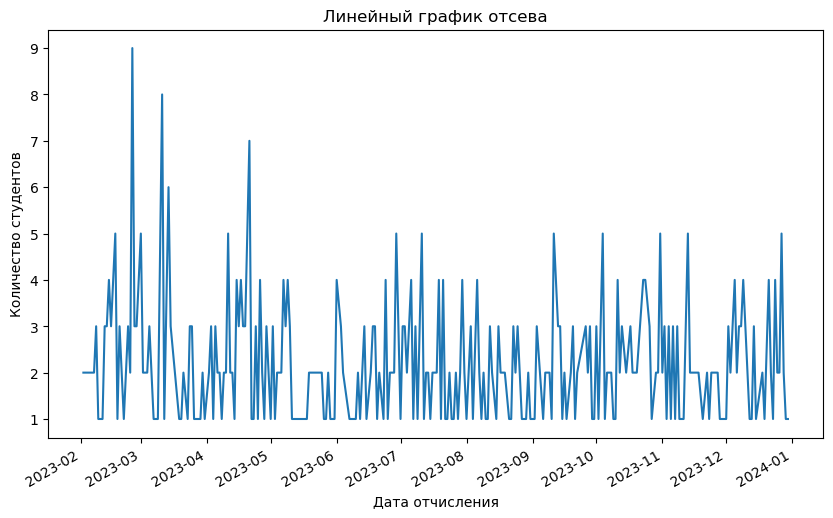

In [117]:
plot_dropout_line(registration_data, 'Линейный график отсева')


In [ ]:
plot_correlation_matrix(students_info_data, 'Корреляционная матрица признаков')


In [22]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

# Загрузка данных
students_info = pd.read_csv('processed_students_info.csv')
activity_df = pd.read_csv('processed_students_activity.csv')
assignments_df = pd.read_csv('processed_students_assignments.csv')


# Агрегирование данных
activity_agg = activity_df.groupby('код_сотрудник')['длительность_пребывания'].sum().reset_index()
assignments_agg = assignments_df.groupby('код_сотрудник')['оценка'].mean().reset_index()

# Объединение данных
data = students_info.merge(activity_agg, on='код_сотрудник', how='left').merge(assignments_agg, on='код_сотрудник', how='left')
data = data.fillna(0)

# Подготовка данных для обучения
def prepare_data(data):
    X = data.drop(columns=['статус', 'код_сотрудник'])
    y = data['статус'].apply(lambda x: 1 if x == 'прошел курс' else 0)
    return X, y

X, y = prepare_data(data)

# Кодирование категориальных переменных
categorical_features = ['отдел', 'должность']
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough')

# Настройки для GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth': [4, 6, 8],
    'classifier__criterion': ['gini', 'entropy']
}

# Создание и обучение модели
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(random_state=42))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Оценка модели
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

# Сохранение модели и данных
joblib.dump(best_model, 'best_dropout_model.pkl')
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)
y_pred_df = pd.DataFrame(y_pred, columns=['predictions'])
y_pred_df.to_csv('y_pred.csv', index=False)

C:\Users\khusn\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


              precision    recall  f1-score   support

           0       0.52      0.42      0.47       107
           1       0.46      0.56      0.50        93

    accuracy                           0.48       200
   macro avg       0.49      0.49      0.48       200
weighted avg       0.49      0.48      0.48       200

Accuracy: 0.485


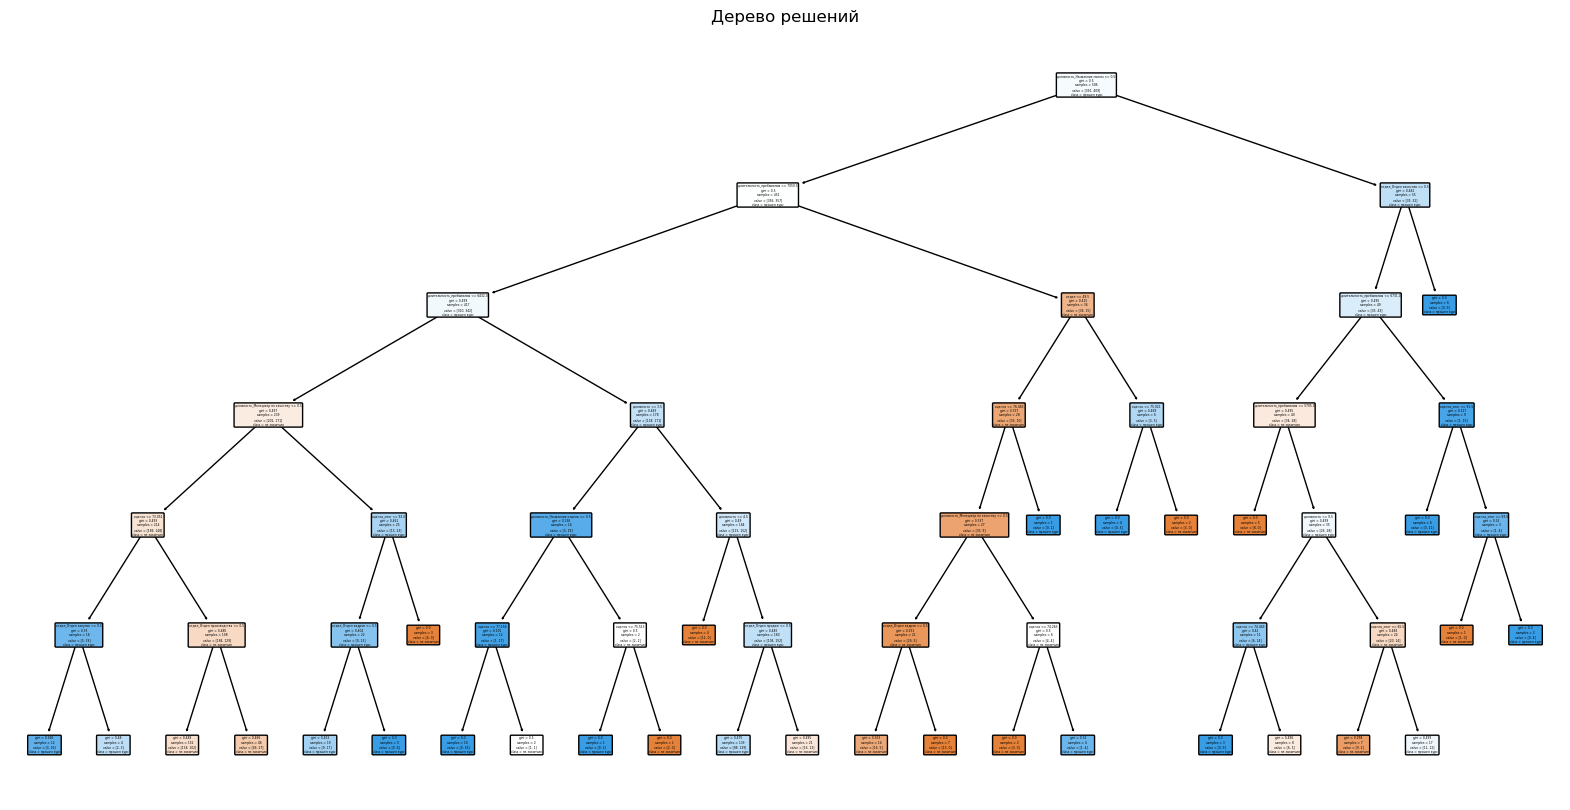

In [29]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Визуализация и сохранение дерева решений
def plot_and_save_decision_tree(model, X, file_name='decision_tree.png'):
    # Получение названий признаков после OneHotEncoding
    feature_names = model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features).tolist() + X.columns[len(categorical_features):].tolist()
    plt.figure(figsize=(20, 10))
    plot_tree(model.named_steps['classifier'].estimators_[0], feature_names=feature_names, filled=True, rounded=True, class_names=['не закончил', 'прошел курс'])
    plt.title('Дерево решений')
    plt.savefig(file_name)
    plt.show()

# Вызов функции визуализации и сохранения
plot_and_save_decision_tree(best_model, X_test)



<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
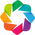

TypeError: '<=' not supported between instances of 'int' and 'str'

:Bars   [Важность]   (Признак)

In [40]:
import pandas as pd
import hvplot.pandas
import holoviews as hv
from holoviews import opts

hv.extension('bokeh')

# Визуализация важности признаков
def plot_feature_importance(model, X):
    # Получение названий признаков после OneHotEncoding
    feature_names = model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features).tolist() + X.columns[len(categorical_features):].tolist()
    importances = model.named_steps['classifier'].feature_importances_
    feature_importance_df = pd.DataFrame({'Признак': feature_names, 'Важность': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Важность', ascending=False)
    
    # Убедимся, что все данные имеют правильный тип
    feature_importance_df['Признак'] = feature_importance_df['Признак'].astype(str)
    feature_importance_df['Важность'] = feature_importance_df['Важность'].astype(float)
    
    # Визуализация с hvplot, оси поменяны местами
    plot = feature_importance_df.hvplot.barh(
        y='Признак', x='Важность', color="#5170ff", title='Важность признаков', 
        ylabel='Признак', xlabel='Важность'
    ).opts(
        opts.Bars(width=800, height=400, line_color='white', xlabel='Важность', ylabel='Признак')
    )
    return plot

# Вызов функции визуализации
plot_feature_importance(best_model, X_test)

  


In [ ]:
# Построение модели удержания студентов
X, y = prepare_data(students_info_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = train_model(X_train, y_train)
y_pred = evaluate_model(model, X_test, y_test)

# Важность признаков
feature_importance_df = feature_importance(model, X_train)

# Визуализация дерева решений
visualize_decision_tree(model, X_train)
